# Point Cloud Generation

Importing modules to be used.

In [1]:
import pybullet as p
import cv2
import open3d as o3d
import numpy as np 
import pybullet_data
import matplotlib.pyplot as plt
import math
import jdc
import threading
from IPython.display import Image, Video
from mpl_toolkits.mplot3d import Axes3D
import Camera

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Create simulation environment with an object.

In [2]:
def initialize_simulator():
    global sim
    sim = p.connect(p.GUI)
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.loadURDF('plane.urdf')
    p.loadURDF('r2d2.urdf', [0,0,1], globalScaling = 1)
    p.setGravity(0,0,-10)

The function defined below will map the GUI sliders' names and values to a dictionary, and then return this dictionary.

In [3]:
class PointCloud:
    @classmethod
    def read_params(self, params):
        self.params = params
        vals = dict()
        self.vals = vals
        for name, param in self.params.items():
            self.vals[name] = p.readUserDebugParameter(param)
        return self.vals

This function develops the sliders for the parameters in the GUI.

In [4]:
%%add_to PointCloud
@classmethod
def camera_placement(self, p_scale = 1., max_dist = 10., show_plot = True, verbose = True):
    np.set_printoptions(suppress = True, precision = 4)
    self.cam = dict()
    self.cam['x'] = p.addUserDebugParameter(' x', -p_scale, p_scale, 0)
    self.cam['y'] = p.addUserDebugParameter(' y', -p_scale, p_scale, 0)
    self.cam['z'] = p.addUserDebugParameter(' z', -p_scale, p_scale, 0)
    self.cam['dist'] = p.addUserDebugParameter(' distance', 0, max_dist, max_dist/2)
    self.cam['roll'] = p.addUserDebugParameter(' roll', -180, 180, 0)
    self.cam['pitch'] = p.addUserDebugParameter(' pitch', -180, 180, -40)
    self.cam['yaw'] = p.addUserDebugParameter(' yaw', -180, 180, 0)
    self.cam['upAxisIndex'] = p.addUserDebugParameter(' toggle upAxisIndex', 1,0,1)
    self.cam['width'] = p.addUserDebugParameter(' width', 100, 1000, 320)
    self.cam['height'] = p.addUserDebugParameter(' height', 100, 1000, 240)
    self.cam['fov'] = p.addUserDebugParameter(' fov', 1, 180, 50)
    self.cam['near'] = p.addUserDebugParameter(' near', 1e-6, 1, .1)
    self.cam['far'] = p.addUserDebugParameter(' far', 1, 100, 10)
    self.cam['print'] = p.addUserDebugParameter('print', 1, 0, 1)

This function generaties the bodies of the camera and its target.

In [5]:
%%add_to PointCloud
@classmethod
def generate_bodies(self):
    self.target_vis_id = p.createVisualShape(p.GEOM_SPHERE, radius = .01, rgbaColor = [1, 0, 0, .7])
    self.target_body = p.createMultiBody(0,-1, self.target_vis_id)
    self.camera_vis_id = p.createVisualShape(p.GEOM_BOX, halfExtents = [.02, .05, .02], rgbaColor = [1, 0, 0, .7])
    self.camera_body = p.createMultiBody(0,-1, self.camera_vis_id)

This function generates and saves the depth and RGB images, as well as the point cloud. <br> Since we can't directly extract the focal length of the camera used in Pybullet, we can alternatively calculate it using the field of view and width of the image with the following equation: <br><p style="text-align: center;"> $focal\_length = \frac{0.5 * image\_width}{\tan(\frac{fov}{2})}$</p>
 


In [6]:
%%add_to PointCloud
@classmethod
def generate_images(self):
            while 1:
                self.values = self.read_params(self.cam)
                target_pos = np.array([self.values[c] for c in 'xyz'])
                upAxisIndex = (int(self.values['upAxisIndex']) % 2 ) + 1
                view_mtx = p.computeViewMatrixFromYawPitchRoll(target_pos, self.values['dist'],self.values['yaw'],self.values['pitch'],self.values['roll'],upAxisIndex=2)     
                
                height = int(self.values['height'])
                width = int(self.values['width'])
                aspect = width/height
                proj_mtx = p.computeProjectionMatrixFOV(self.values['fov'],aspect,self.values['near'], self.values['far'])
                p.resetBasePositionAndOrientation(self.target_body, target_pos, [0,0,0,1])
                view_mtx = np.array(view_mtx).reshape((4,4),order='F')
                trans_mtx = np.linalg.inv(view_mtx)        
                cam_pos = np.dot(view_mtx[:3,:3].T, -view_mtx[:3,3])
                cam_euler = np.radians([self.values['pitch'],self.values['roll'],self.values['yaw']])
                cam_quat = p.getQuaternionFromEuler(cam_euler)
                p.resetBasePositionAndOrientation(self.camera_body, cam_pos, cam_quat)
                
                view_mtx = view_mtx.reshape(-1, order='F')
                
                self.img = p.getCameraImage(width, height, view_mtx, proj_mtx, renderer = p.ER_TINY_RENDERER)
                width, height, self.rgb, self.depth, mask = self.img
                self.depth*=255
                self.depth = np.where(self.depth < 255, self.depth*.5, self.depth)
                cv2.imwrite('rgb.png',cv2.cvtColor(self.rgb,cv2.COLOR_RGBA2BGR))
                
                cv2.imwrite('depth.png', self.depth)
                np.save('depth.npy', self.depth)
                self.rgb = cv2.imread("rgb.png")
                self.rgb = cv2.cvtColor(self.rgb, cv2.COLOR_BGRA2RGB)
                cx = self.depth.shape[1] // 2
                cy = self.depth.shape[0] // 2
                xx, yy = np.meshgrid(np.arange(self.depth.shape[1]), np.arange(self.depth.shape[0]))
                f = .5 * self.depth.shape[1] / math.tan(self.values['fov']*(math.pi/180)/2)
                fx = fy = f
                xx = (xx - cx) / fx * self.depth
                yy = (yy - cy) / fy * self.depth

                points = np.column_stack((xx.flatten(), yy.flatten(), self.depth.flatten()))
                colors = self.rgb.reshape(-1, 3) / 255.0

            
             



                    # Create the point cloud and save it to a PLY file
                pcd = o3d.geometry.PointCloud()
                pcd.points = o3d.utility.Vector3dVector(points)
                pcd.colors = o3d.utility.Vector3dVector(colors)
                o3d.io.write_point_cloud("testingpointcloud.ply", pcd)

                image = cv2.imread('rgb.png')
                cam_depth = np.load('depth.npy')
                flx = 5500
                fly = 7500
                cam = Camera.Camera(img_size=(640, 480),focal_length=(flx, fly),img_center=(320, 240),rotation=np.eye(3),translation=np.zeros(3)) #change these values
                cam.add_image(image,cam_depth)
                cam.point_cloud()
                print(cam.pcd)
                print(cam.pcd_o3d)
                o3d.io.write_point_cloud("girishpointcloud.ply", cam.pcd_o3d)

                # Display PCD
                # cam.visualize()
                    # Get PCD using O3D's built-in fcn
                '''
                self.depth = self.depth.astype(np.float32) 
                rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(self.rgb), o3d.geometry.Image(self.depth), depth_scale=1.0, depth_trunc=3.0, convert_rgb_to_intensity=False)
                pcd_o3d = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
               # pcd_o3d.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
                o3d.io.write_point_cloud("testingpointcloud_o3d.ply", pcd_o3d) 
                '''
                
                if (p.getConnectionInfo(sim)['isConnected'] == 0):
                    break     
            old_print_val = 1
            if old_print_val != self.values['print']:
                    old_print_val = self.values['print']
                    print("\n========================================")
                    print(f"VIEW MATRIX : \n{np.array_str(view_mtx)}")
                    print(f"PROJECTION MATRIX : \n{np.array(proj_mtx)}")
                    if True:
                        print(f"target position : {np.array_str(target_pos)}")
                        print(f"distance : {self.values['dist']:.2f}")
                        print(f"yaw : {self.values['yaw']:.2f}")
                        print(f"pitch : {self.values['pitch']:.2f}")
                        print(f"roll : {self.values['roll']:.2f}")
                        print(f"width : {width:d}")
                        print(f"height : {height:d}")
                        print(f"fov : {self.values['fov']:.1f}")
                        print(f"aspect : {aspect:.2f}")
                        print(f"nearVal : {self.values['near']:.2f}")
                        print(f"farVal : {self.values['far']:.2f}")
                        print(np.array(trans_mtx))
                        print("========================================\n")
                
                
           
        
                    
        

Generate GUI for user to interact with point cloud visualization, saves point cloud as PNG file.

In [7]:
def visualize_point_cloud():
    pcd = o3d.io.read_point_cloud("testingpointcloud.ply")
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.capture_screen_image("pointcloud.png")
    vis.destroy_window()


Displays RGB, Depth, and Point Cloud Image

In [8]:
def plot_images():
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize = (10,5))
    im1 = "rgb.png"
    im2 = "depth.png"
    im3 = "pointcloud.png"
    img1 = cv2.imread(im1)
    img2 = cv2.imread(im2)
    img3 = cv2.imread(im3)
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)
    ax1.imshow(img1)
    ax1.axis('off')
    ax1.set_title("RGB Image")
    ax2.imshow(img2)
    ax2.axis('off')
    ax2.set_title('Depth Image')
    ax3.imshow(img3)
    ax3.axis('off')
    ax3.set_title('Point Cloud')


[[-14.8364  -8.16   255.    ]
 [-14.79    -8.16   255.    ]
 [-14.7436  -8.16   255.    ]
 ...
 [ -0.0681  -0.0166 124.7807]
 [ -0.0454  -0.0166 124.7807]
 [ -0.0227  -0.0166 124.7807]]
PointCloud with 76800 points.
[[-14.8364  -8.16   255.    ]
 [-14.79    -8.16   255.    ]
 [-14.7436  -8.16   255.    ]
 ...
 [ -0.0681  -0.0166 124.7807]
 [ -0.0454  -0.0166 124.7807]
 [ -0.0227  -0.0166 124.7807]]
PointCloud with 76800 points.
[[-14.8364  -8.16   255.    ]
 [-14.79    -8.16   255.    ]
 [-14.7436  -8.16   255.    ]
 ...
 [ -0.0681  -0.0166 124.7807]
 [ -0.0454  -0.0166 124.7807]
 [ -0.0227  -0.0166 124.7807]]
PointCloud with 76800 points.
[[-14.8364  -8.16   255.    ]
 [-14.79    -8.16   255.    ]
 [-14.7436  -8.16   255.    ]
 ...
 [ -0.0681  -0.0166 124.7807]
 [ -0.0454  -0.0166 124.7807]
 [ -0.0227  -0.0166 124.7807]]
PointCloud with 76800 points.
[[-14.8364  -8.16   255.    ]
 [-14.79    -8.16   255.    ]
 [-14.7436  -8.16   255.    ]
 ...
 [ -0.0681  -0.0166 124.7807]
 [ -0.0454 

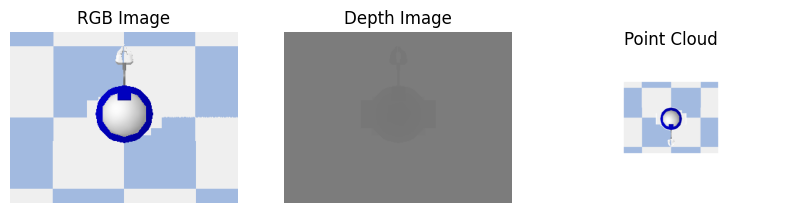

In [9]:
if __name__ == "__main__":
    initialize_simulator()
    PointCloud.camera_placement()
    PointCloud.generate_bodies()
    PointCloud.generate_images()
    visualize_point_cloud()
    plot_images()
   


  
#transformation matrix applies some rotation and translation 
           